# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="pic1.png"/>

Then you will want to run the above command:

<img src="pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

In [1]:
import pandas as pd
import numpy as np
import math
import json
import matplotlib.pyplot as plt
import datetime
import seaborn as sns
import datetime
import pickle
# read in the json files


In [2]:
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

In [3]:
portfolio.head()

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7


In [4]:
portfolio.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   reward      10 non-null     int64 
 1   channels    10 non-null     object
 2   difficulty  10 non-null     int64 
 3   duration    10 non-null     int64 
 4   offer_type  10 non-null     object
 5   id          10 non-null     object
dtypes: int64(3), object(3)
memory usage: 608.0+ bytes


In [5]:
profile.head()

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN


In [6]:
profile.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            14825 non-null  object 
 1   age               17000 non-null  int64  
 2   id                17000 non-null  object 
 3   became_member_on  17000 non-null  int64  
 4   income            14825 non-null  float64
dtypes: float64(1), int64(2), object(2)
memory usage: 664.2+ KB


In [7]:
transcript.head()

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0


In [8]:
transcript.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306534 entries, 0 to 306533
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   person  306534 non-null  object
 1   event   306534 non-null  object
 2   value   306534 non-null  object
 3   time    306534 non-null  int64 
dtypes: int64(1), object(3)
memory usage: 9.4+ MB


In [9]:
# Cleaning portfolio dataframe
# change the duration from day to hour
cleaned_portfolio = portfolio.copy()
cleaned_portfolio['duration'] = cleaned_portfolio['duration'] * 24
    
# apply one hot encoding to channels column
cleaned_portfolio['web'] = cleaned_portfolio['channels'].apply(lambda x: 1 if 'web' in x else 0)
cleaned_portfolio['email'] = cleaned_portfolio['channels'].apply(lambda x: 1 if 'email' in x else 0)
cleaned_portfolio['mobile'] = cleaned_portfolio['channels'].apply(lambda x: 1 if 'mobile' in x else 0)
cleaned_portfolio['social'] = cleaned_portfolio['channels'].apply(lambda x: 1 if 'social' in x else 0)
    
# apply one hot encoding to offer_type column
offer_type = pd.get_dummies(cleaned_portfolio['offer_type'])
    
# drop the channels and offer_type column
cleaned_portfolio.drop(['channels'], axis=1, inplace=True)
    
# combine the portfolio and offer_type dataframe to form a cleaned dataframe
cleaned_portfolio = pd.concat([cleaned_portfolio, offer_type], axis=1, sort=False)


In [10]:
# Cleaning profile dataframe
# age: (numeric) missing value encoded as 118
cleaned_profile = profile.copy()
cleaned_profile['age'] = cleaned_profile['age'].apply(lambda x: np.nan if x == 118 else x)  
# drop all missing values
cleaned_profile.dropna(inplace=True)
    
# the number of days since the user is a memeber of starbucks
cleaned_profile['memberdays'] = datetime.datetime.today().date() - pd.to_datetime(profile['became_member_on'], format='%Y%m%d').dt.date

cleaned_profile['memberdays'] = cleaned_profile['memberdays'].dt.days

Text(0.5, 0, 'Income')

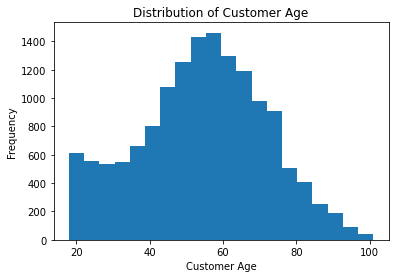

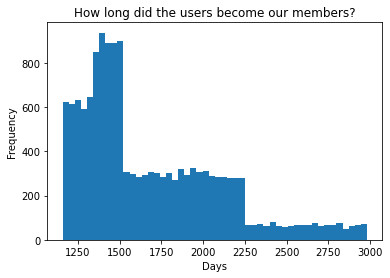

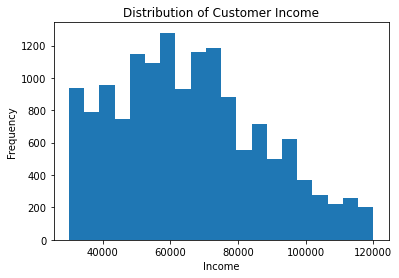

In [11]:
# Display customer profile with histograms
user_age = cleaned_profile['age'].plot(kind='hist', bins=20, title='Distribution of Customer Age')
user_age.set_xlabel("Customer Age")   
# Display Histogram of the days being member
plt.figure()
memberdays = cleaned_profile['memberdays'].plot(kind='hist', bins=50, title='How long did the users become our members?')
memberdays.set_xlabel("Days")    
# Display Histogram of User Income
plt.figure()
user_income = cleaned_profile['income'].plot(kind='hist', bins=20, title='Distribution of Customer Income')
user_income.set_xlabel("Income")

C:\App\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


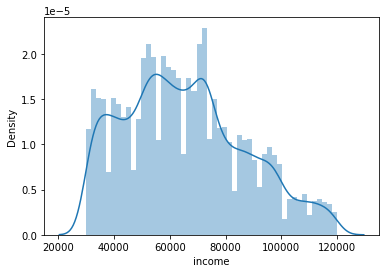

In [12]:
# income distribution
sns.distplot(cleaned_profile['income'], kde = True, bins = 50)
plt.show()

# Display Histogram of User Income
#plt.figure()
#user_income = cleaned_profile['income'].plot(kind='hist', bins=20, title='Distribution of Customer Income')
#user_income.set_xlabel("Income")

C:\App\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\App\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


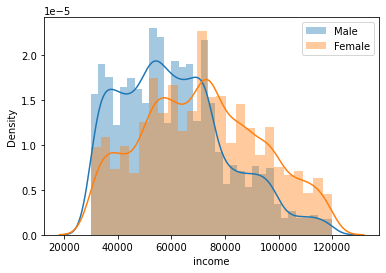

In [13]:
## Gender Income Distribution
sns.distplot(profile[profile.gender=='M'].income,label='Male')
sns.distplot(profile[profile.gender=='F'].income,label='Female')
plt.legend()
plt.show()

In [14]:
# Cleaning profile dataframe
offer = transcript.copy()
# extract the rows that are related to offer action (e.g. offer received, offer viewed, offer completed)
offer = transcript[transcript['value'].apply(lambda x: True if ('offer id' in x) or ('offer_id' in x) else False)] 
# extract the offer id from value column
offer['offer_id'] = offer['value'].apply(lambda x: x['offer id'] if ('offer id' in x) else x['offer_id'])
offer['id'] = offer['offer_id']

<ipython-input-14-9dc4110ad52b>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  offer['offer_id'] = offer['value'].apply(lambda x: x['offer id'] if ('offer id' in x) else x['offer_id'])
<ipython-input-14-9dc4110ad52b>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  offer['id'] = offer['offer_id']


In [15]:
def merge_datasets(portfolio_clean, profile_clean, transcript_clean):
    """ Merge the three data sets into one
    Input:
    - portfolio_clean
    - profile_clean
    - transcript_clean
    Output:
    - df: merged dataframe
    """
    trans_prof = pd.merge(transcript_clean, profile_clean, on='id',
                          how="left")
    df = pd.merge(trans_prof, portfolio_clean, on='id', how='left')
    # Change the offer ids to a simplied form
    offer_id = {'ae264e3637204a6fb9bb56bc8210ddfd': 'B1',
                '4d5c57ea9a6940dd891ad53e9dbe8da0': 'B2',
                '9b98b8c7a33c4b65b9aebfe6a799e6d9': 'B3',
                'f19421c1d4aa40978ebb69ca19b0e20d': 'B4',
                '0b1e1539f2cc45b7b9fa7c272da2e1d7': 'D1',
                '2298d6c36e964ae4a3e7e9706d1fb8c2': 'D2',
                'fafdcd668e3743c1bb461111dcafc2a4': 'D3',
                '2906b810c7d4411798c6938adc9daaa5': 'D4',
                '3f207df678b143eea3cee63160fa8bed': 'I1',
                '5a8bc65990b245e5a138643cd4eb9837': 'I2'}
    df.offer_id = df.offer_id.apply(lambda x: offer_id[x] if x else None)

    return df

In [16]:
cleaned_portfolio.head()

,reward,difficulty,duration,offer_type,id,web,email,mobile,social,bogo,discount,informational
0,10,10,168,bogo,ae264e3637204a6fb9bb56bc8210ddfd,0,1,1,1,1,0,0
1,10,10,120,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0,1,1,1,1,1,0,0
2,0,0,96,informational,3f207df678b143eea3cee63160fa8bed,1,1,1,0,0,0,1
3,5,5,168,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,1,1,0,1,0,0
4,5,20,240,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,1,0,0,0,1,0


In [17]:
cleaned_profile.head()

,gender,age,id,became_member_on,income,memberdays
1,F,55.0,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0,1534
3,F,75.0,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0,1601
5,M,68.0,e2127556f4f64592b11af22de27a7932,20180426,70000.0,1249
8,M,65.0,389bc3fa690240e798340f5a15918d5c,20180209,53000.0,1325
12,M,58.0,2eeac8d8feae4a8cad5a6af0499a211d,20171111,51000.0,1415


In [18]:
offer.head()

,person,event,value,time,offer_id,id
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0,9b98b8c7a33c4b65b9aebfe6a799e6d9,9b98b8c7a33c4b65b9aebfe6a799e6d9
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0,0b1e1539f2cc45b7b9fa7c272da2e1d7,0b1e1539f2cc45b7b9fa7c272da2e1d7
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0,2906b810c7d4411798c6938adc9daaa5,2906b810c7d4411798c6938adc9daaa5
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0,fafdcd668e3743c1bb461111dcafc2a4,fafdcd668e3743c1bb461111dcafc2a4
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0,4d5c57ea9a6940dd891ad53e9dbe8da0,4d5c57ea9a6940dd891ad53e9dbe8da0


In [19]:
df = merge_datasets(cleaned_portfolio, cleaned_profile, offer)

In [20]:
df.head()

,person,event,value,time,offer_id,id,gender,age,became_member_on,income,...,difficulty,duration,offer_type,web,email,mobile,social,bogo,discount,informational
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0,B3,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,NaN,NaN,NaN,...,5,168,bogo,1,1,1,0,1,0,0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0,D1,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,NaN,NaN,NaN,...,20,240,discount,1,1,0,0,0,1,0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0,D4,2906b810c7d4411798c6938adc9daaa5,NaN,NaN,NaN,NaN,...,10,168,discount,1,1,1,0,0,1,0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0,D3,fafdcd668e3743c1bb461111dcafc2a4,NaN,NaN,NaN,NaN,...,10,240,discount,1,1,1,1,0,1,0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0,B2,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN,NaN,NaN,NaN,...,10,120,bogo,1,1,1,1,1,0,0


In [21]:
df.offer_type.describe()

count     167581
unique         3
top         bogo
freq       71617
Name: offer_type, dtype: object

C:\App\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


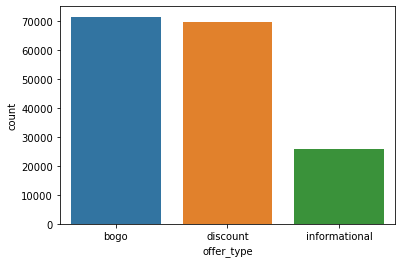

In [22]:
# offer type destribution
sns.countplot(df['offer_type'].dropna())
plt.show()

C:\App\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


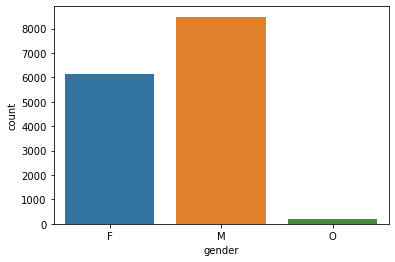

In [23]:
import seaborn as sns
# Gender destribution
sns.countplot(profile['gender'].dropna())
plt.show()

C:\App\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


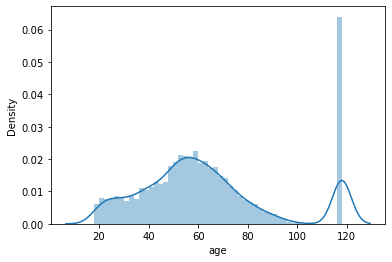

In [24]:
# Age distribution
sns.distplot(profile['age'], kde = True, bins = 50)
plt.show()

C:\App\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\App\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


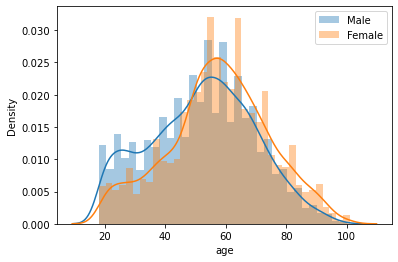

In [25]:
## Gender age distribution
sns.distplot(profile[profile.gender=='M'].age,label='Male')
sns.distplot(profile[profile.gender=='F'].age,label='Female')
plt.legend()
plt.show()

In [26]:
def userItemMatrix(offer, filename):
    '''
    Return the user item matrix that indicate the number of offer complete of a particular user
    
    INPUT:
    offer - a cleaned transcript dataframe
    filename(string) - the file name that save the user item matrix
    
    OUTPUT:
    user_item_matrix - the user item matrix which 
        - row is user 
        - column is offer
        - value is the number of offer complete by the user (NaN means no offer given)
    
    '''
    # create an empty user item matrix
    user_item_matrix = offer.groupby(['person', 'offer_id'])['event'].agg(lambda x: np.nan).unstack()
    # we just focus on bogo and discount first
    user_item_matrix.drop(list(portfolio[portfolio['offer_type']=='informational']['id']), axis=1, inplace=True)
    
    for offer_id in user_item_matrix.columns:
        print("Now processing: ", offer_id)
        num = 0
        for person in user_item_matrix.index:
            num += 1
            if num % 1000 == 0:
                print("finished ", num/16994*100, '%')
            events = []
            for event in offer[(offer['offer_id']==offer_id) & (offer['person']==person)]['event']:
                events.append(event)
            if len(events) >= 3:
                user_item_matrix.loc[person, offer_id] = 0
                for i in range(len(events)-2):
                    # check if the transaction sequence is offer received -> offer viewed -> offer completed
                    # if yes, we assume the user reacted positively with the offer we provided.
                    if (events[i] == 'offer received') & (events[i+1] == 'offer viewed') & (events[i+2] == 'offer completed'):
                        user_item_matrix.loc[person, offer_id] += 1
            elif len(events) > 0:
                user_item_matrix.loc[person, offer_id] = 0
    
    # store the large martix into file
    fh = open(filename, 'wb')
    pickle.dump(user_item_matrix,fh)
    fh.close()
    
    return user_item_matrix
full_df = userItemMatrix(offer, 'user_item_matrix.p')

Now processing:  0b1e1539f2cc45b7b9fa7c272da2e1d7
finished  5.884429798752501 %
finished  11.768859597505003 %
finished  17.653289396257502 %
finished  23.537719195010006 %
finished  29.422148993762505 %
finished  35.306578792515005 %
finished  41.19100859126751 %
finished  47.07543839002001 %
finished  52.95986818877251 %
finished  58.84429798752501 %
finished  64.7287277862775 %
finished  70.61315758503001 %
finished  76.4975873837825 %
finished  82.38201718253502 %
finished  88.26644698128752 %
finished  94.15087678004002 %
Now processing:  2298d6c36e964ae4a3e7e9706d1fb8c2
finished  5.884429798752501 %
finished  11.768859597505003 %
finished  17.653289396257502 %
finished  23.537719195010006 %
finished  29.422148993762505 %
finished  35.306578792515005 %
finished  41.19100859126751 %
finished  47.07543839002001 %
finished  52.95986818877251 %
finished  58.84429798752501 %
finished  64.7287277862775 %
finished  70.61315758503001 %
finished  76.4975873837825 %
finished  82.38201718253

In [27]:
train_size = int(offer.shape[0]*0.8)
test_size = offer.shape[0] - train_size
train_size, test_size
train_offer = offer[:train_size]
test_offer = offer[train_size:]
train_df = userItemMatrix(train_offer, 'train_df.p')

Now processing:  0b1e1539f2cc45b7b9fa7c272da2e1d7
finished  5.884429798752501 %
finished  11.768859597505003 %
finished  17.653289396257502 %
finished  23.537719195010006 %
finished  29.422148993762505 %
finished  35.306578792515005 %
finished  41.19100859126751 %
finished  47.07543839002001 %
finished  52.95986818877251 %
finished  58.84429798752501 %
finished  64.7287277862775 %
finished  70.61315758503001 %
finished  76.4975873837825 %
finished  82.38201718253502 %
finished  88.26644698128752 %
finished  94.15087678004002 %
Now processing:  2298d6c36e964ae4a3e7e9706d1fb8c2
finished  5.884429798752501 %
finished  11.768859597505003 %
finished  17.653289396257502 %
finished  23.537719195010006 %
finished  29.422148993762505 %
finished  35.306578792515005 %
finished  41.19100859126751 %
finished  47.07543839002001 %
finished  52.95986818877251 %
finished  58.84429798752501 %
finished  64.7287277862775 %
finished  70.61315758503001 %
finished  76.4975873837825 %
finished  82.38201718253

In [28]:
test_df = userItemMatrix(test_offer, 'test_df.p')

Now processing:  0b1e1539f2cc45b7b9fa7c272da2e1d7
finished  5.884429798752501 %
finished  11.768859597505003 %
finished  17.653289396257502 %
finished  23.537719195010006 %
finished  29.422148993762505 %
finished  35.306578792515005 %
finished  41.19100859126751 %
finished  47.07543839002001 %
finished  52.95986818877251 %
finished  58.84429798752501 %
finished  64.7287277862775 %
finished  70.61315758503001 %
finished  76.4975873837825 %
finished  82.38201718253502 %
Now processing:  2298d6c36e964ae4a3e7e9706d1fb8c2
finished  5.884429798752501 %
finished  11.768859597505003 %
finished  17.653289396257502 %
finished  23.537719195010006 %
finished  29.422148993762505 %
finished  35.306578792515005 %
finished  41.19100859126751 %
finished  47.07543839002001 %
finished  52.95986818877251 %
finished  58.84429798752501 %
finished  64.7287277862775 %
finished  70.61315758503001 %
finished  76.4975873837825 %
finished  82.38201718253502 %
Now processing:  2906b810c7d4411798c6938adc9daaa5
fini

In [29]:
def FunkSVD(complete_mat, latent_features=12, learning_rate=0.0001, iters=100):
    '''
    This function performs matrix factorization using a basic form of FunkSVD with no regularization
    
    INPUT:
    complete_mat - (numpy array) a matrix with users as rows, offers as columns, and offer completed as values
    latent_features - (int) the number of latent features used
    learning_rate - (float) the learning rate 
    iters - (int) the number of iterations
    
    OUTPUT:
    user_mat - (numpy array) a user by latent feature matrix
    offer_mat - (numpy array) a latent feature by offer matrix
    '''
    
    # Set up useful values to be used through the rest of the function
    n_users = complete_mat.shape[0]
    n_offers = complete_mat.shape[1]
    num_complete = np.count_nonzero(~np.isnan(complete_mat))
    
    # initialize the user and movie matrices with random values
    user_mat = np.random.rand(n_users, latent_features)
    offer_mat = np.random.rand(latent_features, n_offers)
    
    # initialize sse at 0 for first iteration
    sse_accum = 0
    
    # keep track of iteration and MSE
    print("Optimizaiton Statistics")
    print("Iterations | Mean Squared Error ")
    
    # for each iteration
    for iteration in range(iters):

        # update our sse
        old_sse = sse_accum
        sse_accum = 0
        
        # For each user-offer pair
        for i in range(n_users):
            for j in range(n_offers):
                
                # if the rating exists
                if complete_mat[i, j] >= 0:
                    
                    # compute the error as the actual minus the dot product of the user and offer latent features
                    diff = complete_mat[i, j] - np.dot(user_mat[i, :], offer_mat[:, j])
                    
                    # Keep track of the sum of squared errors for the matrix
                    sse_accum += diff**2
                    
                    # update the values in each matrix in the direction of the gradient
                    for k in range(latent_features):
                        user_mat[i, k] += learning_rate * (2*diff*offer_mat[k, j])
                        offer_mat[k, j] += learning_rate * (2*diff*user_mat[i, k])

        # print results
        print("%d \t\t %f" % (iteration+1, sse_accum / num_complete))
        
    return user_mat, offer_mat

In [30]:
# Create user-by-item matrix - nothing to do here
train_data_np = np.array(train_df)

# Test for the best number of latent feature. (with latent features 12)
user_mat_12, offer_mat_12 = FunkSVD(train_data_np, latent_features=12, learning_rate=0.005, iters=250)

Optimizaiton Statistics
Iterations | Mean Squared Error 
1 		 0.316915
2 		 0.284186
3 		 0.283647
4 		 0.283097
5 		 0.282544
6 		 0.281985
7 		 0.281422
8 		 0.280853
9 		 0.280278
10 		 0.279697
11 		 0.279109
12 		 0.278513
13 		 0.277909
14 		 0.277297
15 		 0.276675
16 		 0.276042
17 		 0.275399
18 		 0.274743
19 		 0.274075
20 		 0.273393
21 		 0.272695
22 		 0.271982
23 		 0.271251
24 		 0.270501
25 		 0.269731
26 		 0.268940
27 		 0.268125
28 		 0.267285
29 		 0.266418
30 		 0.265523
31 		 0.264596
32 		 0.263637
33 		 0.262643
34 		 0.261612
35 		 0.260541
36 		 0.259428
37 		 0.258270
38 		 0.257064
39 		 0.255808
40 		 0.254499
41 		 0.253133
42 		 0.251709
43 		 0.250224
44 		 0.248673
45 		 0.247056
46 		 0.245368
47 		 0.243607
48 		 0.241771
49 		 0.239857
50 		 0.237863
51 		 0.235788
52 		 0.233629
53 		 0.231385
54 		 0.229056
55 		 0.226641
56 		 0.224139
57 		 0.221552
58 		 0.218880
59 		 0.216125
60 		 0.213288
61 		 0.210372
62 		 0.207380
63 		 0.204316
64 		 0

In [31]:
# Test for the best number of latent feature. (with latent features 9)
user_mat_9, offer_mat_9 = FunkSVD(train_data_np, latent_features=9, learning_rate=0.005, iters=250)

Optimizaiton Statistics
Iterations | Mean Squared Error 
1 		 0.308679
2 		 0.284219
3 		 0.283547
4 		 0.282874
5 		 0.282199
6 		 0.281522
7 		 0.280843
8 		 0.280161
9 		 0.279477
10 		 0.278789
11 		 0.278099
12 		 0.277404
13 		 0.276707
14 		 0.276005
15 		 0.275298
16 		 0.274587
17 		 0.273871
18 		 0.273149
19 		 0.272421
20 		 0.271687
21 		 0.270946
22 		 0.270197
23 		 0.269439
24 		 0.268673
25 		 0.267898
26 		 0.267112
27 		 0.266315
28 		 0.265506
29 		 0.264685
30 		 0.263850
31 		 0.263000
32 		 0.262134
33 		 0.261252
34 		 0.260351
35 		 0.259431
36 		 0.258491
37 		 0.257529
38 		 0.256543
39 		 0.255533
40 		 0.254496
41 		 0.253431
42 		 0.252337
43 		 0.251211
44 		 0.250052
45 		 0.248858
46 		 0.247628
47 		 0.246358
48 		 0.245049
49 		 0.243697
50 		 0.242301
51 		 0.240859
52 		 0.239369
53 		 0.237829
54 		 0.236239
55 		 0.234595
56 		 0.232897
57 		 0.231144
58 		 0.229334
59 		 0.227466
60 		 0.225539
61 		 0.223553
62 		 0.221508
63 		 0.219403
64 		 0

In [32]:
# Test for the best number of latent feature. (with latent features 6)
user_mat_6, offer_mat_6 = FunkSVD(train_data_np, latent_features=6, learning_rate=0.005, iters=250)

Optimizaiton Statistics
Iterations | Mean Squared Error 
1 		 0.298114
2 		 0.284320
3 		 0.283371
4 		 0.282421
5 		 0.281469
6 		 0.280518
7 		 0.279566
8 		 0.278614
9 		 0.277662
10 		 0.276709
11 		 0.275755
12 		 0.274801
13 		 0.273846
14 		 0.272890
15 		 0.271933
16 		 0.270975
17 		 0.270016
18 		 0.269056
19 		 0.268094
20 		 0.267131
21 		 0.266165
22 		 0.265198
23 		 0.264228
24 		 0.263256
25 		 0.262281
26 		 0.261303
27 		 0.260322
28 		 0.259337
29 		 0.258348
30 		 0.257355
31 		 0.256357
32 		 0.255355
33 		 0.254346
34 		 0.253332
35 		 0.252311
36 		 0.251284
37 		 0.250248
38 		 0.249205
39 		 0.248154
40 		 0.247093
41 		 0.246023
42 		 0.244942
43 		 0.243849
44 		 0.242745
45 		 0.241629
46 		 0.240499
47 		 0.239354
48 		 0.238195
49 		 0.237020
50 		 0.235828
51 		 0.234619
52 		 0.233390
53 		 0.232143
54 		 0.230875
55 		 0.229585
56 		 0.228273
57 		 0.226937
58 		 0.225577
59 		 0.224192
60 		 0.222780
61 		 0.221340
62 		 0.219872
63 		 0.218375
64 		 0

In [33]:
def predict_reaction(user_matrix, offer_matrix, user_id, offer_id):
    '''
    We can use this to make predictions for how users would react with the offers
    
    INPUT:
    user_matrix - user by latent factor matrix
    offer_matrix - latent factor by offer matrix
    user_id - the user_id from the reviews df
    offer_id - the offer_id according the offers df
    
    OUTPUT:
    pred - the predicted reaction for user_id-offer_id according to FunkSVD
    '''
    try:
        # Use the training data to create a series of users and movies that matches the ordering in training data
        user_ids_series = np.array(train_df.index)
        offer_ids_series = np.array(train_df.columns)

        # User row and Movie Column
        user_row = np.where(user_ids_series == user_id)[0][0]
        offer_col = np.where(offer_ids_series == offer_id)[0][0]

        # Take dot product of that row and column in U and V to make prediction
        pred = np.dot(user_matrix[user_row, :], offer_matrix[:, offer_col])
        
        return pred
    
    except:
        #print("I'm sorry, but a prediction cannot be made for this user-offer pair.  It looks like one of these items does not exist in our current database.")
    
        return None

In [35]:
def validation(test_df, user_mat, offer_mat):
    '''Measure the squared errors for the prediction'''
    num_complete = np.count_nonzero(~np.isnan(test_df))
    
    sse_accum = 0
    
    for user_id in test_df.index:
        for offer_id in test_df.columns:
            if ~np.isnan(test_df.loc[user_id, offer_id]):
                predict_value = predict_reaction(user_mat, offer_mat, user_id, offer_id)
                if predict_value != None:
                    # compute the error as the actual minus the dot product of the user and offer latent features
                    diff = test_df.loc[user_id, offer_id] - predict_reaction(user_mat, offer_mat, user_id, offer_id)

                    # Keep track of the sum of squared errors for the matrix
                    sse_accum += diff**2
    
    print(sse_accum / num_complete)

In [36]:
# Evaluation for latent features of 12
validation(test_df, user_mat_12, offer_mat_12)

0.35417338310410523


In [37]:
# Evaluation for latent features of 9
validation(test_df, user_mat_9, offer_mat_9)

0.3421164775929542


In [38]:
# Evaluation for latent features of 6
validation(test_df, user_mat_6, offer_mat_6)

0.32957631399511705


In [39]:
#deciding the number of latent features
num_latent_feats = np.arange(10+4)
sum_errs = []

for k in num_latent_feats:
    # Test for the best number of latent feature. (with latent features k)
    user_mat, offer_mat = FunkSVD(train_data_np, latent_features=k, learning_rate=0.005, iters=250)
    
    # Evaluation for latent features of k
    err = validation(test_df, user_mat, offer_mat)
    
    # Keep track of the sum of squared errors for the matrix
    sum_errs.append(err)
    
    
plt.plot(num_latent_feats, 1 - np.array(sum_errs)/df.shape[0]);
plt.xlabel('Number of Latent Features');
plt.ylabel('Accuracy');
plt.title('Accuracy vs. Number of Latent Features');

Optimizaiton Statistics
Iterations | Mean Squared Error 
1 		 0.447396
2 		 0.447396
3 		 0.447396
4 		 0.447396
5 		 0.447396
6 		 0.447396
7 		 0.447396
8 		 0.447396
9 		 0.447396
10 		 0.447396
11 		 0.447396
12 		 0.447396
13 		 0.447396
14 		 0.447396
15 		 0.447396
16 		 0.447396
17 		 0.447396
18 		 0.447396
19 		 0.447396
20 		 0.447396
21 		 0.447396
22 		 0.447396
23 		 0.447396
24 		 0.447396
25 		 0.447396
26 		 0.447396
27 		 0.447396
28 		 0.447396
29 		 0.447396
30 		 0.447396
31 		 0.447396
32 		 0.447396
33 		 0.447396
34 		 0.447396
35 		 0.447396
36 		 0.447396
37 		 0.447396
38 		 0.447396
39 		 0.447396
40 		 0.447396
41 		 0.447396
42 		 0.447396
43 		 0.447396
44 		 0.447396
45 		 0.447396
46 		 0.447396
47 		 0.447396
48 		 0.447396
49 		 0.447396
50 		 0.447396
51 		 0.447396
52 		 0.447396
53 		 0.447396
54 		 0.447396
55 		 0.447396
56 		 0.447396
57 		 0.447396
58 		 0.447396
59 		 0.447396
60 		 0.447396
61 		 0.447396
62 		 0.447396
63 		 0.447396
64 		 0

15 		 0.265320
16 		 0.262903
17 		 0.260504
18 		 0.258123
19 		 0.255761
20 		 0.253420
21 		 0.251099
22 		 0.248801
23 		 0.246525
24 		 0.244272
25 		 0.242043
26 		 0.239839
27 		 0.237661
28 		 0.235508
29 		 0.233382
30 		 0.231282
31 		 0.229210
32 		 0.227165
33 		 0.225148
34 		 0.223160
35 		 0.221199
36 		 0.219268
37 		 0.217365
38 		 0.215490
39 		 0.213645
40 		 0.211829
41 		 0.210042
42 		 0.208283
43 		 0.206554
44 		 0.204853
45 		 0.203181
46 		 0.201537
47 		 0.199922
48 		 0.198335
49 		 0.196776
50 		 0.195244
51 		 0.193740
52 		 0.192263
53 		 0.190813
54 		 0.189389
55 		 0.187992
56 		 0.186620
57 		 0.185274
58 		 0.183953
59 		 0.182656
60 		 0.181384
61 		 0.180136
62 		 0.178911
63 		 0.177710
64 		 0.176531
65 		 0.175374
66 		 0.174239
67 		 0.173125
68 		 0.172032
69 		 0.170960
70 		 0.169907
71 		 0.168874
72 		 0.167860
73 		 0.166864
74 		 0.165887
75 		 0.164927
76 		 0.163985
77 		 0.163059
78 		 0.162149
79 		 0.161256
80 		 0.160377
81 		 0.15

33 		 0.246692
34 		 0.245401
35 		 0.244112
36 		 0.242827
37 		 0.241544
38 		 0.240263
39 		 0.238984
40 		 0.237707
41 		 0.236432
42 		 0.235159
43 		 0.233887
44 		 0.232616
45 		 0.231345
46 		 0.230075
47 		 0.228806
48 		 0.227536
49 		 0.226266
50 		 0.224996
51 		 0.223724
52 		 0.222450
53 		 0.221175
54 		 0.219898
55 		 0.218618
56 		 0.217335
57 		 0.216049
58 		 0.214758
59 		 0.213463
60 		 0.212163
61 		 0.210858
62 		 0.209548
63 		 0.208230
64 		 0.206906
65 		 0.205575
66 		 0.204236
67 		 0.202889
68 		 0.201533
69 		 0.200167
70 		 0.198793
71 		 0.197407
72 		 0.196012
73 		 0.194605
74 		 0.193187
75 		 0.191757
76 		 0.190315
77 		 0.188860
78 		 0.187393
79 		 0.185912
80 		 0.184419
81 		 0.182912
82 		 0.181391
83 		 0.179857
84 		 0.178309
85 		 0.176748
86 		 0.175173
87 		 0.173585
88 		 0.171983
89 		 0.170369
90 		 0.168742
91 		 0.167104
92 		 0.165453
93 		 0.163791
94 		 0.162119
95 		 0.160436
96 		 0.158745
97 		 0.157045
98 		 0.155337
99 		 0.15

51 		 0.229833
52 		 0.228245
53 		 0.226624
54 		 0.224969
55 		 0.223280
56 		 0.221558
57 		 0.219801
58 		 0.218009
59 		 0.216184
60 		 0.214325
61 		 0.212432
62 		 0.210506
63 		 0.208548
64 		 0.206558
65 		 0.204539
66 		 0.202489
67 		 0.200412
68 		 0.198309
69 		 0.196181
70 		 0.194029
71 		 0.191856
72 		 0.189664
73 		 0.187454
74 		 0.185229
75 		 0.182991
76 		 0.180742
77 		 0.178484
78 		 0.176219
79 		 0.173950
80 		 0.171679
81 		 0.169407
82 		 0.167138
83 		 0.164874
84 		 0.162615
85 		 0.160365
86 		 0.158125
87 		 0.155897
88 		 0.153683
89 		 0.151484
90 		 0.149301
91 		 0.147137
92 		 0.144992
93 		 0.142868
94 		 0.140766
95 		 0.138686
96 		 0.136629
97 		 0.134597
98 		 0.132590
99 		 0.130609
100 		 0.128653
101 		 0.126724
102 		 0.124821
103 		 0.122946
104 		 0.121097
105 		 0.119275
106 		 0.117481
107 		 0.115713
108 		 0.113972
109 		 0.112259
110 		 0.110571
111 		 0.108910
112 		 0.107275
113 		 0.105665
114 		 0.104080
115 		 0.102521
116 		 0.

69 		 0.205833
70 		 0.203542
71 		 0.201205
72 		 0.198824
73 		 0.196400
74 		 0.193935
75 		 0.191432
76 		 0.188893
77 		 0.186320
78 		 0.183715
79 		 0.181082
80 		 0.178424
81 		 0.175743
82 		 0.173043
83 		 0.170327
84 		 0.167597
85 		 0.164859
86 		 0.162113
87 		 0.159365
88 		 0.156617
89 		 0.153873
90 		 0.151135
91 		 0.148407
92 		 0.145692
93 		 0.142993
94 		 0.140312
95 		 0.137652
96 		 0.135015
97 		 0.132405
98 		 0.129823
99 		 0.127272
100 		 0.124753
101 		 0.122268
102 		 0.119818
103 		 0.117406
104 		 0.115032
105 		 0.112697
106 		 0.110403
107 		 0.108151
108 		 0.105940
109 		 0.103771
110 		 0.101645
111 		 0.099562
112 		 0.097523
113 		 0.095526
114 		 0.093572
115 		 0.091660
116 		 0.089791
117 		 0.087964
118 		 0.086178
119 		 0.084433
120 		 0.082728
121 		 0.081063
122 		 0.079436
123 		 0.077847
124 		 0.076295
125 		 0.074779
126 		 0.073299
127 		 0.071853
128 		 0.070441
129 		 0.069061
130 		 0.067713
131 		 0.066395
132 		 0.065108
133 		 

87 		 0.125025
88 		 0.122360
89 		 0.119748
90 		 0.117190
91 		 0.114685
92 		 0.112232
93 		 0.109831
94 		 0.107481
95 		 0.105182
96 		 0.102932
97 		 0.100731
98 		 0.098578
99 		 0.096472
100 		 0.094412
101 		 0.092397
102 		 0.090426
103 		 0.088497
104 		 0.086611
105 		 0.084766
106 		 0.082960
107 		 0.081195
108 		 0.079467
109 		 0.077777
110 		 0.076124
111 		 0.074506
112 		 0.072924
113 		 0.071376
114 		 0.069862
115 		 0.068381
116 		 0.066933
117 		 0.065516
118 		 0.064130
119 		 0.062775
120 		 0.061450
121 		 0.060154
122 		 0.058887
123 		 0.057648
124 		 0.056437
125 		 0.055253
126 		 0.054096
127 		 0.052965
128 		 0.051860
129 		 0.050780
130 		 0.049724
131 		 0.048693
132 		 0.047686
133 		 0.046702
134 		 0.045741
135 		 0.044802
136 		 0.043885
137 		 0.042990
138 		 0.042116
139 		 0.041263
140 		 0.040429
141 		 0.039616
142 		 0.038822
143 		 0.038046
144 		 0.037290
145 		 0.036551
146 		 0.035830
147 		 0.035127
148 		 0.034440
149 		 0.033770
150 	

104 		 0.085490
105 		 0.083366
106 		 0.081294
107 		 0.079274
108 		 0.077305
109 		 0.075386
110 		 0.073516
111 		 0.071694
112 		 0.069919
113 		 0.068190
114 		 0.066506
115 		 0.064866
116 		 0.063270
117 		 0.061715
118 		 0.060201
119 		 0.058728
120 		 0.057294
121 		 0.055898
122 		 0.054539
123 		 0.053217
124 		 0.051931
125 		 0.050679
126 		 0.049461
127 		 0.048276
128 		 0.047123
129 		 0.046001
130 		 0.044910
131 		 0.043848
132 		 0.042816
133 		 0.041811
134 		 0.040833
135 		 0.039882
136 		 0.038956
137 		 0.038056
138 		 0.037179
139 		 0.036326
140 		 0.035496
141 		 0.034688
142 		 0.033902
143 		 0.033136
144 		 0.032391
145 		 0.031665
146 		 0.030958
147 		 0.030270
148 		 0.029599
149 		 0.028945
150 		 0.028308
151 		 0.027687
152 		 0.027082
153 		 0.026492
154 		 0.025917
155 		 0.025356
156 		 0.024808
157 		 0.024274
158 		 0.023753
159 		 0.023244
160 		 0.022747
161 		 0.022262
162 		 0.021788
163 		 0.021325
164 		 0.020873
165 		 0.020430
166 		 0

TypeError: unsupported operand type(s) for /: 'NoneType' and 'int'

In [40]:
def recommend_offer(user_id, user_mat, offer_mat):
    recommend = {}
    for offer_id in train_df.columns:
        pred_val = predict_reaction(user_mat, offer_mat, user_id, offer_id)
        if pred_val != None:
            recommend[offer_id] = pred_val
        else:
            break
    if pred_val == None:
        print("Because this user wasn't in our database, we are giving back the top best sale offer recommendations for all users.")
        top_offer = best_sale_offer(full_df)
        for offer_id in top_offer['offer_id']:
            print("offer id: ", offer_id)
    else:
        print("recommend offer for user ", user_id)
        for offer_id, pred_val in sorted(recommend.items(), key=lambda kv:(kv[1], kv[0]), reverse=True):
            print("offer id: ", offer_id, " predicted value: ", round(pred_val,2))

In [44]:
def best_sale_offer(user_item_matrix):
    # Find out which offer sells the best

    offer_gain = []
    for offer_id in user_item_matrix.columns:
        offer_gain.append([offer_id, transcript[(transcript['person'].isin(list(user_item_matrix[user_item_matrix[offer_id]>=1].index)))&(transcript['event']=='transaction')]['value'].apply(lambda x: x['amount']).sum()])

    offer_value = pd.DataFrame(offer_gain, columns=['offer_id', 'gain'])
    offer_value['gain'] = pd.to_numeric(offer_value['gain'])
    offer_value.sort_values(by='gain', ascending=False, inplace=True)
    print(offer_value)
    
    best_sale = offer_value.plot(kind='bar', title='Sale Amount of Different Offers')
    best_sale.set_xlabel('Offer number')
    best_sale.set_ylabel('Sale Amount')
    
    return offer_value

In [45]:
cleaned_profile.head()

,gender,age,id,became_member_on,income,memberdays
1,F,55.0,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0,1534
3,F,75.0,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0,1601
5,M,68.0,e2127556f4f64592b11af22de27a7932,20180426,70000.0,1249
8,M,65.0,389bc3fa690240e798340f5a15918d5c,20180209,53000.0,1325
12,M,58.0,2eeac8d8feae4a8cad5a6af0499a211d,20171111,51000.0,1415


In [46]:
# recommend offer for a particular user
recommend_offer('0610b486422d4921ae7d2bf64640c50b', user_mat, offer_mat)

recommend offer for user  0610b486422d4921ae7d2bf64640c50b
offer id:  2298d6c36e964ae4a3e7e9706d1fb8c2  predicted value:  1.09
offer id:  f19421c1d4aa40978ebb69ca19b0e20d  predicted value:  0.91
offer id:  4d5c57ea9a6940dd891ad53e9dbe8da0  predicted value:  0.11
offer id:  fafdcd668e3743c1bb461111dcafc2a4  predicted value:  0.03
offer id:  9b98b8c7a33c4b65b9aebfe6a799e6d9  predicted value:  -0.03
offer id:  ae264e3637204a6fb9bb56bc8210ddfd  predicted value:  -0.36
offer id:  0b1e1539f2cc45b7b9fa7c272da2e1d7  predicted value:  -0.38
offer id:  2906b810c7d4411798c6938adc9daaa5  predicted value:  -0.91


Because this user wasn't in our database, we are giving back the top best sale offer recommendations for all users.
                           offer_id       gain
7  fafdcd668e3743c1bb461111dcafc2a4  596220.84
1  2298d6c36e964ae4a3e7e9706d1fb8c2  538027.98
6  f19421c1d4aa40978ebb69ca19b0e20d  480555.03
3  4d5c57ea9a6940dd891ad53e9dbe8da0  441918.93
5  ae264e3637204a6fb9bb56bc8210ddfd  423683.27
2  2906b810c7d4411798c6938adc9daaa5  305568.42
4  9b98b8c7a33c4b65b9aebfe6a799e6d9  304361.77
0  0b1e1539f2cc45b7b9fa7c272da2e1d7  218905.94
offer id:  fafdcd668e3743c1bb461111dcafc2a4
offer id:  2298d6c36e964ae4a3e7e9706d1fb8c2
offer id:  f19421c1d4aa40978ebb69ca19b0e20d
offer id:  4d5c57ea9a6940dd891ad53e9dbe8da0
offer id:  ae264e3637204a6fb9bb56bc8210ddfd
offer id:  2906b810c7d4411798c6938adc9daaa5
offer id:  9b98b8c7a33c4b65b9aebfe6a799e6d9
offer id:  0b1e1539f2cc45b7b9fa7c272da2e1d7


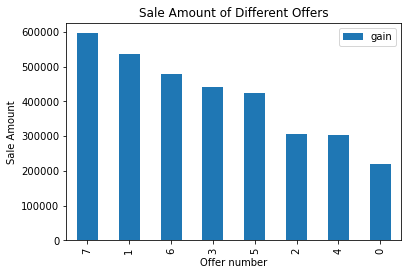

In [47]:
# we recommend top best sale offer to a new user
recommend_offer('new_user', user_mat, offer_mat)

Text(0, 0.5, 'Percentage')

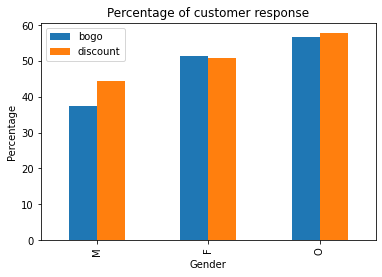

In [48]:
#Find out which type of offer (bogo/discount) attracts most to different gender
# initialize the gender response and the gender sent dataframe
gender_response = pd.DataFrame(data=[[0,0],[0,0],[0,0]], index=['M', 'F', 'O'], columns=['bogo', 'discount'])
gender_sent = pd.DataFrame(data=[[0,0],[0,0],[0,0]], index=['M', 'F', 'O'], columns=['bogo', 'discount'])

# We count the number of offer completed base on the customer gender
for offer_type in ['bogo', 'discount']:
    for offer_id in portfolio[portfolio['offer_type']==offer_type]['id']:
        # count the total number of customers responsed our offers.
        gender_response[offer_type] = gender_response[offer_type].add(profile[profile['id'].isin(full_df[full_df[offer_id]>0].index)]['gender'].value_counts(), fill_value=0)
        # count the total number of offer sent
        gender_sent[offer_type] = gender_sent[offer_type].add(profile[profile['id'].isin(full_df[full_df[offer_id]>=0].index)]['gender'].value_counts(), fill_value=0)
        
gender_offer = (gender_response / gender_sent * 100).plot(kind='bar', title='Percentage of customer response')
gender_offer.set_xlabel("Gender")
gender_offer.set_ylabel("Percentage")

In [50]:
def gender_offer(full_df):
    gender_response = pd.DataFrame(data=[[0,0],[0,0],[0,0]], index=['M', 'F', 'O'], columns=['bogo', 'discount'])
    gender_sent = pd.DataFrame(data=[[0,0],[0,0],[0,0]], index=['M', 'F', 'O'], columns=['bogo', 'discount'])

    # We count the number of offer completed base on the customer gender
    for offer_type in ['bogo', 'discount']:
        for offer_id in portfolio[portfolio['offer_type']==offer_type]['id']:
            # count the total number of customers responsed our offers.
            gender_response[offer_type] = gender_response[offer_type].add(profile[profile['id'].isin(full_df[full_df[offer_id]>0].index)]['gender'].value_counts(), fill_value=0)
            # count the total number of offer sent
            gender_sent[offer_type] = gender_sent[offer_type].add(profile[profile['id'].isin(full_df[full_df[offer_id]>=0].index)]['gender'].value_counts(), fill_value=0)

    gender_offer = (gender_response / gender_sent * 100).plot(kind='bar', title='Percentage of customer response')
    gender_offer.set_xlabel("Gender")
    gender_offer.set_ylabel("Percentage")

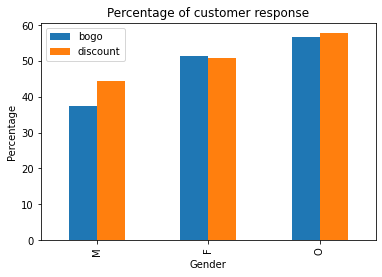

In [51]:
gender_offer(full_df)

In [52]:
def gender_offer_channel(full_df):
    '''
    Find out which type of offer (bogo/discount) attracts most to different gender
    Return with a plotted bar chart
    '''
    
    # initialize the gender response and the gender sent dataframe
    gender_response = pd.DataFrame(data=[[0,0,0,0],[0,0,0,0],[0,0,0,0]], index=['M', 'F', 'O'], columns=['web', 'email', 'mobile', 'social'])
    gender_sent = pd.DataFrame(data=[[0,0,0,0],[0,0,0,0],[0,0,0,0]], index=['M', 'F', 'O'], columns=['web', 'email', 'mobile', 'social'])

    # We count the number of offer completed base on the customer gender
    for channel_type in ['web', 'email', 'mobile', 'social']:
        for offer_id in cleaned_portfolio[(cleaned_portfolio[channel_type]==1)&(cleaned_portfolio['informational']!=1)]['id']:
            # count the total number of customers responsed our offers.
            gender_response[channel_type] = gender_response[channel_type].add(profile[profile['id'].isin(full_df[full_df[offer_id]>0].index)]['gender'].value_counts(), fill_value=0)
            # count the total number of offer sent
            gender_sent[channel_type] = gender_sent[channel_type].add(profile[profile['id'].isin(full_df[full_df[offer_id]>=0].index)]['gender'].value_counts(), fill_value=0)
        
    gender_offer = (gender_response / gender_sent * 100).plot(kind='bar', title='Percentage of customer response')
    gender_offer.set_xlabel("Gender")
    gender_offer.set_ylabel("Percentage")

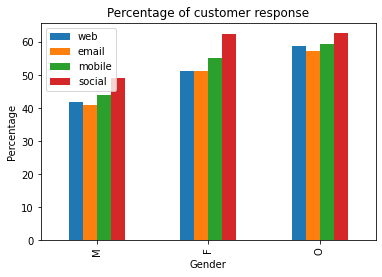

In [53]:
gender_offer_channel(full_df)

                           offer_id       gain
7  fafdcd668e3743c1bb461111dcafc2a4  596220.84
1  2298d6c36e964ae4a3e7e9706d1fb8c2  538027.98
6  f19421c1d4aa40978ebb69ca19b0e20d  480555.03
3  4d5c57ea9a6940dd891ad53e9dbe8da0  441918.93
5  ae264e3637204a6fb9bb56bc8210ddfd  423683.27
2  2906b810c7d4411798c6938adc9daaa5  305568.42
4  9b98b8c7a33c4b65b9aebfe6a799e6d9  304361.77
0  0b1e1539f2cc45b7b9fa7c272da2e1d7  218905.94


,offer_id,gain
7,fafdcd668e3743c1bb461111dcafc2a4,596220.84
1,2298d6c36e964ae4a3e7e9706d1fb8c2,538027.98
6,f19421c1d4aa40978ebb69ca19b0e20d,480555.03
3,4d5c57ea9a6940dd891ad53e9dbe8da0,441918.93
5,ae264e3637204a6fb9bb56bc8210ddfd,423683.27
2,2906b810c7d4411798c6938adc9daaa5,305568.42
4,9b98b8c7a33c4b65b9aebfe6a799e6d9,304361.77
0,0b1e1539f2cc45b7b9fa7c272da2e1d7,218905.94


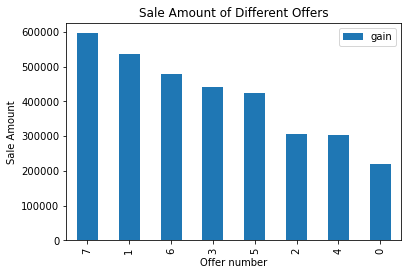

In [54]:


best_sale_offer(full_df)

In [56]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Starbucks_Capstone_notebook (2).ipynb'])

1